In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

from IPython.display import HTML

In [2]:
import operator

import numpy as np

from matplotlib import pyplot as plt
import seaborn as sns

import torch
from torch.utils.data import Subset
from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau

In [3]:
from lib.unpack import unpack_drawings
from lib.strokes import PointsStrokesTransformer
from lib.strokes import VectorsStrokesTransformer
from lib.strokes import PolarStrokesTransformer
from lib.strokes import get_n_points, cut_strokes
from lib.dataset import get_dataset, get_train_val_idxs, get_batches
from lib.dataset import get_means_stds, standarize_data, unstandarize_flat_strokes
from lib.dataset import PADDING_VALUE
from lib.plot import get_canvas, plot, get_animation
from lib.model import Encoder, Decoder, EncoderDecoder
from lib.model import evaluate, generate, train
from lib.model import get_reg_loss, get_classif_loss, get_loss

# Load and show dataset

In [4]:
dataset = unpack_drawings('./data/The Eiffel Tower.bin')
dataset = list(dataset)

In [5]:
good_drawings, bad_drawings = [], []
for item in dataset:
    if item['recognized']:
        good_drawings.append(item['image'])
    else:
        bad_drawings.append(item['image'])

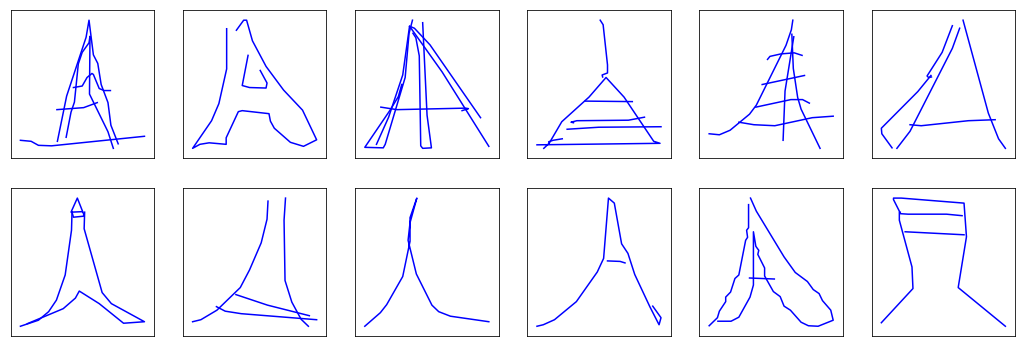

In [6]:
fig, axarr = get_canvas(2, 6)

for i, ax in enumerate(axarr.flatten()):
    plot(good_drawings[i], color='b', ax=ax)

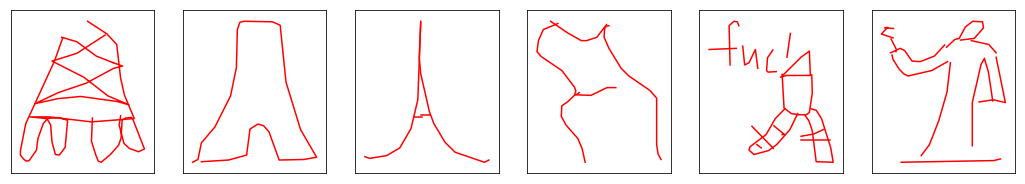

In [7]:
fig, axarr = get_canvas(1, 6)

for i, ax in enumerate(axarr.flatten()):
    plot(bad_drawings[i], color='r', ax=ax)

In [8]:
%%capture
idx = np.random.choice(range(len(good_drawings)))
anim = get_animation(good_drawings[idx])

In [9]:
HTML(anim.to_html5_video())

In [10]:
anim.save('effeil.gif', dpi=80, writer='imagemagick')

# Transform drawings

to an internal representation suitable for modeling

/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0.5,1,'y')

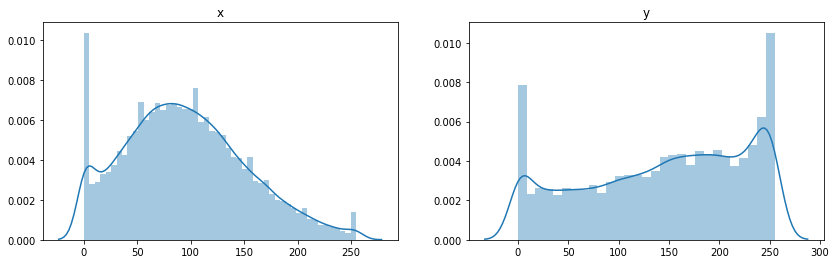

In [11]:
transform = PointsStrokesTransformer().transform
transformed_drawings = [transform(good_drawings[i]) for i in range(1000)]

xs, ys = [], []
for transformed_drawing in transformed_drawings:
    xs += list(map(operator.itemgetter(0), transformed_drawing))
    ys += list(map(operator.itemgetter(1), transformed_drawing))

_, axs = plt.subplots(1, 2, figsize=(14, 4))
sns.distplot(xs, ax=axs[0]).set_title('x')
sns.distplot(ys, ax=axs[1]).set_title('y')

Stroke points do not follow a gaussian distribution.

Text(0.5,1,'delta_y')

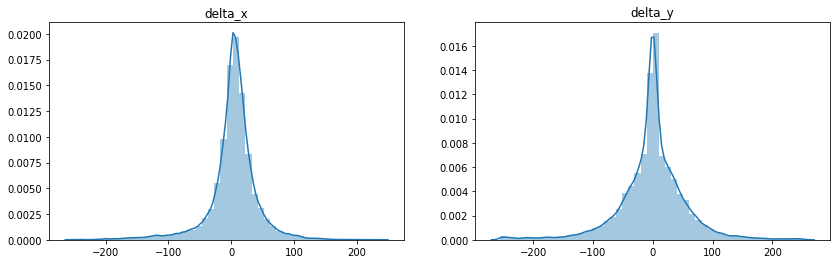

In [12]:
transform = VectorsStrokesTransformer().transform
transformed_drawings = [transform(good_drawings[i]) for i in range(1000)]

delta_xs, delta_ys = [], []
for transformed_drawing in transformed_drawings:
    delta_xs += list(map(operator.itemgetter(0), transformed_drawing))
    delta_ys += list(map(operator.itemgetter(1), transformed_drawing))

_, axs = plt.subplots(1, 2, figsize=(14, 4))
sns.distplot(delta_xs, ax=axs[0]).set_title('delta_x')
sns.distplot(delta_ys, ax=axs[1]).set_title('delta_y')

Stroke vectors follow a gaussian distribution.

Text(0.5,1,'alpha')

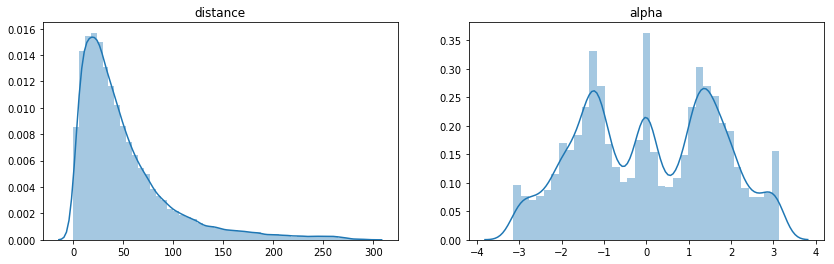

In [13]:
transform = PolarStrokesTransformer().transform
transformed_drawings = [transform(good_drawings[i]) for i in range(1000)]

distances, alphas = [], []
for transformed_drawing in transformed_drawings:
    distances += list(map(operator.itemgetter(0), transformed_drawing))
    alphas += list(map(operator.itemgetter(1), transformed_drawing))

_, axs = plt.subplots(1, 2, figsize=(14, 4))
sns.distplot(distances, ax=axs[0]).set_title('distance')
sns.distplot(alphas, ax=axs[1]).set_title('alpha')

Stroke polar-coordinates vectors do not follow a gaussian distribution.

# Create pytorch dataset

In [14]:
transformer = VectorsStrokesTransformer()
drawings = [drawing for drawing in good_drawings if get_n_points(drawing) > 2]
transformed_drawings = [transformer.transform(drawing) for drawing in drawings]

In [15]:
#idxs = list(range(1))
#transformed_drawings = [transformed_drawings[i] for i in idxs]

In [16]:
ds = get_dataset(transformed_drawings)

In [352]:
train_idxs, val_idxs = get_train_val_idxs(len(ds), sample_ratio=0.1)
#train_idxs, val_idxs = [idxs, idxs]

train_ds = Subset(ds, train_idxs)
val_ds = Subset(ds, val_idxs)

len(train_ds), len(val_ds)

(9812, 3314)

In [353]:
standarize = True
sigmas = 1

if standarize:
    train_means_stds = get_means_stds(train_ds, sigmas)
    val_means_stds = get_means_stds(val_ds, sigmas)
else:
    train_means_stds = ([0, 1], [0, 1])
    val_means_stds = ([0, 1], [0, 1])

In [354]:
# Debug
train_batches = get_batches(train_ds, train_means_stds, batch_size=2)
data_batch, labels_batch, lens_batch = next(iter(train_batches))

print(data_batch.shape, labels_batch.shape, lens_batch.shape)
print()
print()

for tensor in (data_batch, labels_batch, lens_batch):
    print(tensor)
    print()

torch.Size([310, 2, 5]) torch.Size([310, 2, 5]) torch.Size([2])


tensor([[[   2.3798,   -4.1473,    1.0000,    0.0000,    0.0000],
         [  -0.3503,    0.4972,    1.0000,    0.0000,    0.0000]],

        [[   3.1812,    4.0958,    0.0000,    1.0000,    0.0000],
         [  -0.6508,    1.6494,    1.0000,    0.0000,    0.0000]],

        [[  -2.7297,   -3.0482,    1.0000,    0.0000,    0.0000],
         [   0.9521,   -2.2151,    0.0000,    1.0000,    0.0000]],

        ...,

        [[1024.0000, 1024.0000, 1024.0000, 1024.0000, 1024.0000],
         [1024.0000, 1024.0000, 1024.0000, 1024.0000, 1024.0000]],

        [[1024.0000, 1024.0000, 1024.0000, 1024.0000, 1024.0000],
         [1024.0000, 1024.0000, 1024.0000, 1024.0000, 1024.0000]],

        [[1024.0000, 1024.0000, 1024.0000, 1024.0000, 1024.0000],
         [1024.0000, 1024.0000, 1024.0000, 1024.0000, 1024.0000]]],
       device='cuda:0')

tensor([[[   3.1812,    4.0958,    0.0000,    1.0000,    0.0000],
         [  -0.6508,    1

In [355]:
batch_size = 1024
n_hidden = 20

model = EncoderDecoder(batch_size, n_hidden)

if torch.cuda.is_available():
    model = model.cuda()

In [356]:
train_batches = get_batches(train_ds, train_means_stds, batch_size=3)
data_batch, labels_batch, lens_batch = next(iter(train_batches))

preds_batch = model(data_batch, lens_batch)

In [357]:
preds_batch

tensor([[[   0.0666,   -0.0710,    0.3657,    0.3268,    0.3075],
         [   0.2150,    0.0867,    0.3542,    0.2849,    0.3609],
         [   0.2052,    0.0764,    0.3544,    0.2902,    0.3553]],

        [[   0.1579,    0.0832,    0.4028,    0.2670,    0.3302],
         [   0.2244,    0.1130,    0.3565,    0.2755,    0.3680],
         [   0.1977,    0.0713,    0.3529,    0.2937,    0.3534]],

        [[   0.1332,   -0.0388,    0.3434,    0.3077,    0.3488],
         [   0.1223,   -0.0062,    0.3577,    0.3090,    0.3333],
         [   0.1975,    0.0713,    0.3508,    0.2953,    0.3540]],

        ...,

        [[   0.1806,    0.0443,    0.3484,    0.3026,    0.3490],
         [-636.8323,  392.5569,    0.0000,    0.0000,    1.0000],
         [-636.8323,  392.5569,    0.0000,    0.0000,    1.0000]],

        [[   0.1745,    0.0970,    0.3690,    0.2817,    0.3493],
         [-636.8323,  392.5569,    0.0000,    0.0000,    1.0000],
         [-636.8323,  392.5569,    0.0000,    0.0000, 

# Train

In [370]:
batch_size = 1024
n_hidden = 128

model = EncoderDecoder(batch_size, n_hidden)
if torch.cuda.is_available():
    model = model.cuda()

criterion = get_loss
optimizer = Adam(model.parameters(), 1e-2)
scheduler = ReduceLROnPlateau(optimizer, 'min', patience=10, verbose=True)

In [371]:
print(model)

EncoderDecoder(
  (encoder): Encoder(
    (lstm): LSTM(5, 128, bidirectional=True)
  )
  (decoder): Decoder(
    (hidden_bridge): Linear(in_features=256, out_features=128, bias=True)
    (cell_bridge): Linear(in_features=256, out_features=128, bias=True)
    (lstm): LSTM(5, 128)
    (output_weights): Linear(in_features=128, out_features=5, bias=True)
  )
)


In [372]:
train(model, scheduler, criterion, train_ds, val_ds, train_means_stds, val_means_stds, batch_size,
      epochs=100, epochs_between_evals=10)

epoch:   1   train_loss: 1.07678   val_loss: 1.09180         reg_classif_loss_ratio: 8.45
epoch:  10   train_loss: 0.76454   val_loss: 0.75872         reg_classif_loss_ratio: 7.54
epoch:  20   train_loss: 0.62128   val_loss: 0.60382         reg_classif_loss_ratio: 6.30
epoch:  30   train_loss: 0.50903   val_loss: 0.48987         reg_classif_loss_ratio: 5.61
epoch:  40   train_loss: 0.45724   val_loss: 0.44363         reg_classif_loss_ratio: 5.42
epoch:  50   train_loss: 0.42129   val_loss: 0.40732         reg_classif_loss_ratio: 5.04
epoch:  60   train_loss: 0.38816   val_loss: 0.38008         reg_classif_loss_ratio: 4.95
epoch:  70   train_loss: 0.35421   val_loss: 0.35493         reg_classif_loss_ratio: 4.72
epoch:  80   train_loss: 0.41719   val_loss: 0.41849         reg_classif_loss_ratio: 5.52
epoch:  90   train_loss: 0.35826   val_loss: 0.36920         reg_classif_loss_ratio: 5.17
Epoch    98: reducing learning rate of group 0 to 1.0000e-03.
epoch: 100   train_loss: 0.28442   val

In [373]:
torch.save(model.state_dict(), 'model1.pth')

In [374]:
train(model, scheduler, criterion, train_ds, val_ds, train_means_stds, val_means_stds, batch_size,
      epochs=100, epochs_between_evals=10)

epoch:   1   train_loss: 0.27090   val_loss: 0.29053         reg_classif_loss_ratio: 4.42
epoch:  10   train_loss: 0.24906   val_loss: 0.27230         reg_classif_loss_ratio: 4.28
epoch:  20   train_loss: 0.23958   val_loss: 0.26631         reg_classif_loss_ratio: 4.25
epoch:  30   train_loss: 0.23280   val_loss: 0.26207         reg_classif_loss_ratio: 4.25
epoch:  40   train_loss: 0.22612   val_loss: 0.25843         reg_classif_loss_ratio: 4.26
epoch:  50   train_loss: 0.22215   val_loss: 0.25477         reg_classif_loss_ratio: 4.29
epoch:  60   train_loss: 0.21851   val_loss: 0.25218         reg_classif_loss_ratio: 4.33
epoch:  70   train_loss: 0.24115   val_loss: 0.26642         reg_classif_loss_ratio: 4.40
Epoch   172: reducing learning rate of group 0 to 1.0000e-04.
epoch:  80   train_loss: 0.21404   val_loss: 0.24833         reg_classif_loss_ratio: 4.34
epoch:  90   train_loss: 0.20946   val_loss: 0.24746         reg_classif_loss_ratio: 4.34
epoch: 100   train_loss: 0.20750   val

In [375]:
torch.save(model.state_dict(), 'model2.pth')

In [376]:
train(model, scheduler, criterion, train_ds, val_ds, train_means_stds, val_means_stds, batch_size,
      epochs=100, epochs_between_evals=10)

epoch:   1   train_loss: 0.20735   val_loss: 0.24728         reg_classif_loss_ratio: 4.34
epoch:  10   train_loss: 0.20618   val_loss: 0.24723         reg_classif_loss_ratio: 4.35
epoch:  20   train_loss: 0.20511   val_loss: 0.24718         reg_classif_loss_ratio: 4.35
epoch:  30   train_loss: 0.20415   val_loss: 0.24710         reg_classif_loss_ratio: 4.36


KeyboardInterrupt: 

In [377]:
torch.save(model.state_dict(), 'model3.pth')

# Predict

In [530]:
map_location = 'cuda' if torch.cuda.is_available() else 'cpu'
model.load_state_dict(torch.load('model3.pth', map_location=map_location))

In [531]:
n_initial_points = 2

idx = np.random.choice(len(val_ds))
flat_strokes = val_ds[idx][0].tolist()
start_of_stroke = flat_strokes[:n_initial_points]
start_of_stroke = torch.Tensor(start_of_stroke).unsqueeze(dim=1)
standarize_data(start_of_stroke, get_means_stds(val_ds))

if torch.cuda.is_available():
    start_of_stroke = start_of_stroke.cuda()

In [532]:
pred_flat_strokes = generate(model, start_of_stroke, 50)
pred_flat_strokes = unstandarize_flat_strokes(pred_flat_strokes, val_means_stds)
pred_flat_strokes

[[47, -61, 1, 0, 0],
 [32, -64, 1, 0, 0],
 [20, -37, 1, 0, 0],
 [6, 4, 1, 0, 0],
 [1, 5, 1, 0, 0],
 [-3, -14, 1, 0, 0],
 [8, -23, 1, 0, 0],
 [17, 32, 1, 0, 0],
 [29, 106, 1, 0, 0],
 [-45, -17, 0, 1, 0],
 [27, -42, 1, 0, 0],
 [7, -35, 1, 0, 0],
 [1, 21, 1, 0, 0],
 [3, 54, 1, 0, 0],
 [0, 23, 1, 0, 0],
 [-11, -6, 1, 0, 0],
 [-15, -31, 1, 0, 0],
 [-3, -23, 1, 0, 0],
 [-1, -13, 1, 0, 0],
 [-4, 7, 1, 0, 0],
 [-8, 23, 1, 0, 0],
 [-11, 27, 1, 0, 0],
 [-14, 22, 1, 0, 0],
 [-13, 12, 1, 0, 0],
 [-1, -10, 1, 0, 0],
 [30, -39, 1, 0, 0],
 [21, -14, 1, 0, 0],
 [10, -9, 1, 0, 0],
 [0, -1, 1, 0, 0],
 [-4, 4, 1, 0, 0],
 [-6, 4, 1, 0, 0],
 [-5, 1, 1, 0, 0],
 [-2, -4, 1, 0, 0],
 [1, -8, 1, 0, 0],
 [2, -10, 1, 0, 0],
 [1, -7, 1, 0, 0],
 [0, -3, 1, 0, 0],
 [0, 2, 1, 0, 0],
 [0, 5, 1, 0, 0],
 [0, 6, 1, 0, 0],
 [0, 5, 1, 0, 0],
 [0, 3, 1, 0, 0],
 [1, 2, 1, 0, 0],
 [1, 1, 1, 0, 0],
 [1, 1, 1, 0, 0],
 [1, 1, 1, 0, 0],
 [1, 2, 1, 0, 0],
 [1, 2, 1, 0, 0],
 [1, 2, 1, 0, 0],
 [1, 2, 1, 0, 0],
 [1, 2, 1, 0, 0],
 [1,

In [533]:
%%capture

from lib.plot import get_animation

strokes = transformer.inverse_transform(flat_strokes)
anim = get_animation(strokes)

cut_drawing = cut_strokes(strokes, n_initial_points)
cut_anim = get_animation(cut_drawing)

pred_strokes = transformer.inverse_transform(pred_flat_strokes)
pred_anim = get_animation(pred_strokes)

In [534]:
# Ground truth drawing
HTML(anim.to_html5_video())

In [535]:
# Ground truth drawing
HTML(cut_anim.to_html5_video())

In [536]:
# Generated drawing
HTML(pred_anim.to_html5_video())